In [23]:
from typing import (
    List,
    Tuple,
    Dict,
    Optional,
)

import os
import sys
import csv

import altair as alt
import pandas as pd

EXPERIMENT_DIR = 'data/weak_function_experiment_results'

# Read CSV into Data Frame

Here we load our processed data into a pandas data frame to plug in easily to `altair`.

In [24]:
METRICS = {
    'al/valid/f1-measure-overall': 'Span F1',
    'al/valid/precision-measure-overall': 'Span Precision',
    'al/valid/recall-measure-overall': 'Span Recall',
    'al/valid/tag_f1': 'Token F1',
    'al/valid/tag_precision': 'Token Precision',
    'al/valid/tag_recall': 'Token Recall',
}

DataDef = List[
    Dict[str, object]
]

def parse_file(
    file_name: str,
    experiment_tag: str,
    weak_weight: float,
    weak_function: str,
    trial: int,
) -> DataDef:
    output = []
    with open(file_name, 'r') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            # tag, value, step
            metric_name, metric_val, step = row
            if metric_name not in METRICS:
                continue
            output.append({
                'metric_name': METRICS[metric_name],
                'metric_val': round(float(metric_val), 2),
                'step': float(step),
                'tag': experiment_tag,
                'weak_function': weak_function,
                'weak_weight': weak_weight,
                'trial': trial,
            })
    return output

def get_experiment_data(root_dir: str) -> DataDef:
    res = []
    for weak_weight in os.listdir(root_dir):
        weak_weight = float(weak_weight)
        weight_dir = os.path.join(
            root_dir,
            f'{weak_weight}',
        )
        for weak_function in os.listdir(weight_dir):
            weak_function_dir = os.path.join(
                weight_dir,
                weak_function,
            )
            
            for trial_dir in os.listdir(weak_function_dir):
                if not trial_dir.startswith('trial_'):
                    print(f'skipping: {trial_dir}')
                    continue
                trial_num = int(trial_dir[len('trial_'):])
                summary_file = os.path.join(
                    weak_function_dir,
                    trial_dir,
                    'summary.csv',
                )
                
                parsed_data = parse_file(
                    file_name=summary_file,
                    experiment_tag='ADR',
                    weak_weight=weak_weight,
                    weak_function=weak_function,
                    trial=trial_num,
                )
                
                res.extend(parsed_data)
    return res

data = get_experiment_data(EXPERIMENT_DIR)

In [25]:
data_frame = pd.DataFrame(data)
data_frame.head(2)

,metric_name,metric_val,step,tag,trial,weak_function,weak_weight
0,Token F1,0.49,10.0,ADR,2,knn,0.01
1,Token F1,0.65,50.0,ADR,2,knn,0.01


# Visualizations

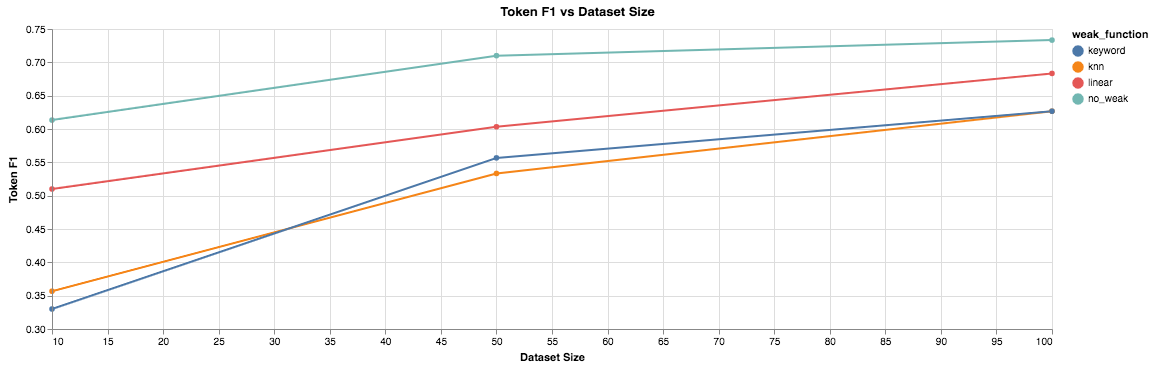

In [34]:
WEAK_WEIGHT = 0.1
MAX_DATASET_SIZE = 10000

def metric_graph(data_frame: pd.DataFrame, metric: str) -> alt.Chart:
    base = alt.Chart(data_frame, title=f'{metric} vs Dataset Size')
    line = base.mark_line(point=True).encode(
        x=alt.X('step', title='Dataset Size'),
        y=alt.Y('mean(metric_val)', title=metric, scale=alt.Scale(zero=False)),
        color='weak_function:N',
    ).transform_filter(
        alt.datum.metric_name == metric
    ).transform_filter(
        alt.datum.weak_weight == WEAK_WEIGHT
    ).transform_filter(
        alt.datum.step <= MAX_DATASET_SIZE
    )
    
    confidence_interval = base.mark_area(interpolate='monotone', opacity=0.3).encode(
        x=alt.X('step'),
        y=alt.Y('ci0(metric_val)', scale=alt.Scale(zero=False)),
        y2='ci1(metric_val)',
        color='weak_function:N',
    ).transform_filter(
        alt.datum.metric_name == metric
    ).transform_filter(
        alt.datum.weak_weight == WEAK_WEIGHT
    ).transform_filter(
        alt.datum.step <= MAX_DATASET_SIZE
    )
    
#     rule = base.mark_rule(stroke_dash=[3,2]).encode(
#         x=alt.X('step', title='Dataset Size'),
#         y=alt.Y('mean(metric_val)', title=metric, scale=alt.Scale(domain=[0, 1])),
#     ).transform_filter(
#         alt.datum.metric_name == metric
#     ).transform_filter(
#         alt.datum.weak_weight == WEAK_WEIGHT
#     ).transform_filter(
#         alt.datum.step <= MAX_DATASET_SIZE
#     ).transform_filter(
#         alt.datum.weak_function == 'no_weak'
#     )
    
#     rule = base.mark_rule(
#         strokeDash=[3,2],
#     ).encode(
#         y='mark_val:Q',
#         size=alt.value(2),
#     ).transform_filter(
#         alt.datum.dataset == dataset
#     ).transform_calculate(
#         mark_val=f'{max_perf[dataset]}',
#     )

    return (line).properties(width=1000)
metric_graph(data_frame, 'Token F1')